In [66]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
import os
import scipy.integrate as integrate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import pandas as pd
import csv
import math
import warnings
from matplotlib import colors
warnings.filterwarnings('ignore')
import random
from astrotools.skymap import PlotSkyPatch

In [67]:
# Transform a matrix into a txt file with the name you pick

# COME BACK TO IT LATER

def data_into_txt(matrix):
    theshit=np.matrix(matrix)
    name=input ('Enter file name: ')
    with open(f'{name}.txt','wb') as f:
        for line in theshit:
            np.savetxt(f, line, fmt='%.2f')


In [68]:
# Important constants in SI units

k=1.380649e-23   # m^2 kg s^-2 K^-1 or J/K
G=6.6743e-11    # m^3 kg^-1 s^-2
e=1.602176634e-19 # A s
h=6.62607015e-34  # m^2 kg s^-1 or J.s
c=299792458        # m/s
sigma= 5.670374419e-8  #W/m^2/K^4
me=510998.950       #eV/c**2
thomson= 6.65245e-25  # cm^2
avg_cmb_photon=6.34e-4 # eV

In [69]:
# Extract 2D plot (x,y) data from CSV file

def data_extractor(directory):
    file=open(directory)
    csvreader=csv.reader(file)
    rows=[]
    for row in csvreader:
        rows.append(row)
    x=[]
    y=[]
    for i in range (len(rows)):
        x.append (rows[i][0])
        y.append (rows[i][1])
    for i in range (len(x)):
        x[i]=float(x[i])
        y[i]=float(y[i])
    return (x,y)

In [70]:
# Unit exchange:
# Way=1 ---> kelvin to cm-1
# Way=2 ---> cm to kelvin

def hz_to_ev(hz,way):
    if way==1:
        return (hz*4.1357e-15)
    elif way==2:
        return (hz/4.1357e-15)
    
def kelvin_to_cm(kelvin, way):
    if way==1:
        return (kelvin*1e4/(11606*1.23981))
    elif way==2:
        return (kelvin/1e4*11606*1.23981)
    
def kelvin_to_ev(kelvin,way):
    if way==1:
        return(kelvin/11606)
    elif way==2:
        return (kelvin*11606)
    
def ev_to_cm(ev,way):
    if way==1:
        return (ev*1e4/1.23981)
    elif way==2:
        return (ev/1e4*1.23981)

    #cm-1 to kpc-1  
def cm_to_kpc(cm,way):
    if way==1:
        return (cm/3.24e-22)
    elif way==2:
        return (cm*3.24e-22)

In [71]:
# Useful Functions

# KE in eV
def KE(T):
    return (k*T/e ,'eV')

#photon energy in eV
def photon_E(mu,T):
    E=h*mu
    return (E/e)

# Midpoint integration
def midpoint_rule(a,b,n,f):
    h=(b-a)/n
    X1=[]
    X2=[]
    for i in range(0,n):
        x1=a+(i*h)
        X1.append(x1)
    for j in range (1,n+1):
        x2=a+(j*h)
        X2.append(x2)
    X_value1 = np.array(X1)
    X_value2 = np.array(X2)
    X_midpoint=(X_value1+X_value2)/2
    I=h*(sum(f(X_midpoint)))
    return I

#trapezoidal online

def trape(x0,xn,n):
    # calculating step size
    h = (xn - x0) / n
    
    # Finding sum 
    integration = N(x0) + N(xn)
    
    for i in range(1,n):
        k = x0 + i*h
        integration = integration + 2 * N(k)
    
    # Finding final integration value
    integration = integration * h/2
    
    return integration

# RK4
T=kelvin_to_cm(2.7255,1)
def f(x,y):
    return 8*np.pi*T**3*x**2/(np.exp(x/T)-1)

def rk4(x0,y0,xn,n):
    h=(xn-x0)/n
    for i in range (n):
        k1 = h * (f(x0, y0))
        k2 = h * (f((x0+h/2), (y0+k1/2)))
        k3 = h * (f((x0+h/2), (y0+k2/2)))
        k4 = h * (f((x0+h), (y0+k3)))
        k = (k1+2*k2+2*k3+k4)/6
        yn = y0 + k
        y0 = yn
        x0 = x0+h
    return (f(xn,yn))

# Avg spectrum energy
def avg_E(E,N):
    avg=0
    for i in range (len(E)):
        avg=avg+ N[i]*E[i]
    avg=avg/(sum(N))
    return (avg)

# Boltzmann distribution probability

def prob(wvlg,T):
    z=0
    for i in (lambdas):
         z=z+ np.exp(-h*c/i/k/T)
    prob=np.exp(-h*c/wvlg/k/T)/z
    return (prob)

# Rayleigh Jeans spectrum

def ray_jeans(T):
    Bs=[]
    for i in (mus):
        B= 8*np.pi*i**2*k*T/c**3
        Bs.append (B)
    plt.plot (mus, Bs)
    plt.title ('Rayleigh-Jeans Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Spectral Radiance')
    plt.xlim([0,1e15])
    plt.ylim([0,3e-15])
    
# Wavelength domain

def black_body(T,lambdas):
    Bs=[]
    for i in (lambdas):
        B= 8*np.pi*h*c/(i**4)*(1/(np.exp(h*c/i/k/T)-1))/1e6/e
        Bs.append (B)
        
    lambdas=lambdas*1e6
    return (lambdas, Bs)
    
# frequency domain
def black_body_freq(T,mus):
    N=[]
    E=[]
    for i in (mus):
        
        E.append(photon_E(i,T))
        
        x=h*i/k/T
        x=np.float128(x)
    
        y=8*(np.pi)*i**3/c**3/1e6
        y=np.float128(y)
        
        B= y/(np.exp(x)-1)
        N.append (B)
    return (N,E)
    
#energy domain

def bb_energy(T):
    
    #Define the energy range you  want or uncomment this one (corresponds to CMB range)
    #energies=np.logspace (-9,-2,1000)
    N=[]
    for i in (energies):
        
        x=i*e/k/T
        x=np.float128(x)
        
        y=8* np.pi* (i*e)**3 /(h*c)**3 /1e6 # remove/add division by i to get back to eps.n(eps)
        y=np.float128(y)
        
        B= y/(np.exp(x)-1)
        N.append (B)
    return (N)

In [107]:
# Calculate number density for dust

# Define the modified black body for dust
def MBB(T,beta,ref_mu,mus,I0):
    N=[]
    E=[]
    for i in (mus):
        
        E.append(photon_E(i,T))
        
        x=h*i/k/T
        x=np.float128(x)
        
        y=8*np.pi*i**3/c**3/1e6*I0*(i/ref_mu)**beta
        
        ##
        #y=2*h*i**3/c**2/e/1e4*I0*(i/ref_mu)**beta
        #y=ev_to_cm(y,1)
        ##
        y=np.float128(y)
        
        B= y/(np.exp(x)-1)
        N.append (B)
        
    return (E,N)

In [8]:
def MBB_EN(T,beta,ref_mu,mus,I0):
    E_d=[]
    lambdas=[]
    for i in mus:
        lambdas.append (c/i*1e6)
        x=h*i/k/T
        x=np.float128(x)
        
        y=(8*np.pi*i**3/c**3)/1e6*I0*(i/ref_mu)**beta*h*i/e
        y=np.float128(y)
        
        B= y/(np.exp(x)-1)
        E_d.append (B)
    return (E_d,lambdas)

In [9]:
# Calculate Number density for CMB
mus=np.logspace (8,13,1000)
CMB_N=black_body_freq(2.7255,mus)[0]
CMB_E=black_body_freq(2.7255,mus)[1]

In [73]:
# CMB Number density
# Extracting points from Lipari and LEE to compare 
# By using a function written above 'data_extractor'

# Vernetto Lipari
numb_density='/home/chris/Desktop/APC_internship/extractor/numb_density_datapoints_verlipary.csv'
x_n=data_extractor(numb_density)[0]
y_n=data_extractor(numb_density)[1]

# Lee
nb_density_Lee='/home/chris/Desktop/APC_internship/extractor/Lee_NbDensity.csv'
x2_n=data_extractor (nb_density_Lee)[0]
y2_n=data_extractor(nb_density_Lee)[1]

In [108]:
# Calculate number density for dust
muss=[]
epsilon_range_dust=np.logspace (-4,-1,1000)
for i in epsilon_range_dust:
    muss.append (i*e/h)
    
nb_density_dust=MBB(T=19.7,beta=1.62,ref_mu=353e9,mus=muss,I0=9.6e-7)[1]

# Modified Number density
nb_density_dust2=[]
for i in nb_density_dust:
    nb_density_dust2.append (i*20)

In [105]:
# Extract Number density for dust

N_dust='/home/chris/Desktop/APC_internship/extractor/N_dust_vernLip.csv'
x_Ndust=data_extractor(N_dust)[0]
y_Ndust=data_extractor(N_dust)[1]

EBL='/home/chris/Desktop/APC_internship/extractor/EBL.csv'
x_EBL=data_extractor(EBL)[0]
y_EBL=data_extractor(EBL)[1]

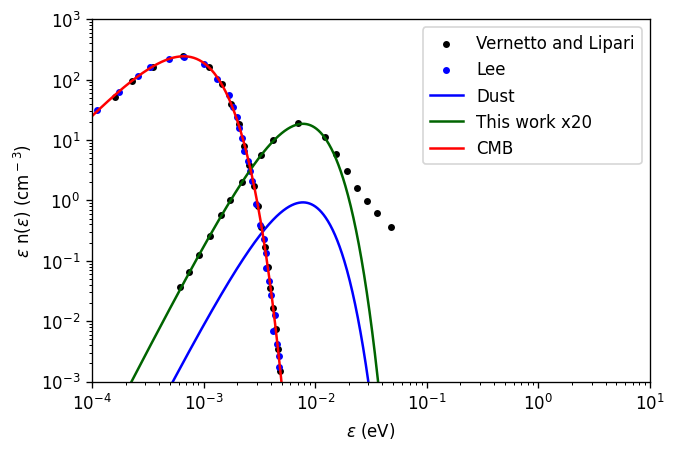

In [109]:
plt.figure (dpi=120)
# Scatter Lipari and Lee Data
plt.scatter (x_Ndust,y_Ndust, label='Vernetto and Lipari', s=10, color='black')
plt.scatter (x_n,y_n,color='black',s=(10))
plt.scatter (x2_n,y2_n, color='blue', label='Lee', s=(10))

#EBL
#plt.scatter (x_EBL,y_EBL, label='EBL', s=10, color='grey')

# Plot my data and x20 data
plt.plot (epsilon_range_dust,nb_density_dust,color='Blue', label='Dust')
plt.plot (epsilon_range_dust, nb_density_dust2, color= 'darkgreen', label= 'This work x20')

# Plot CMB number density 
plt.plot (CMB_E,CMB_N,color='red', label='CMB')

plt.xscale ('log')
plt.yscale ('log')

plt.xlim([1e-4, 10])
plt.ylim([1e-3,1e3])

plt.xlabel ('$\epsilon$ (eV)')
plt.ylabel('$\epsilon$ n($\epsilon$) (cm$^-$$^3$)')

plt.legend()

In [14]:
# Calculate CMB E density
lambdas=np.linspace(1e-5,1,10000)
CMB_Ed=black_body(2.7255,lambdas)[1]
CMB_wvlg=black_body(2.7255,lambdas)[0]

In [15]:
# CMB En density
# Extracting points from Lipari and Vernetto to compare
# By using a function written above 'data_extractor'

en_density='/home/chris/Desktop/APC_internship/extractor/Edensity_datapoints_VernLiparri.csv'
x_en_density=data_extractor(en_density)[0]
y_en_density=data_extractor(en_density)[1]

In [16]:
# Calculate en density Dust

E_density_dust=MBB_EN(T=19.7,beta=1.62,ref_mu=353e9,mus=muss,I0=9.6e-7)[0]
lambda_range= MBB_EN(T=19.7,beta=1.62,ref_mu=353e9,mus=muss,I0=9.6e-7)[1]

E_density_dust2=[]
for i in E_density_dust:
    E_density_dust2.append (i*20)

In [17]:
# Extract Dust E density points 

firas='/home/chris/Desktop/APC_internship/extractor/COBE-Firas_E_dens.csv'
xFiras=data_extractor(firas)[0]
yFiras=data_extractor(firas)[1]

lipari='/home/chris/Desktop/APC_internship/extractor/Dust_E_dens.csv'
xLipari= data_extractor(lipari)[0]
yLipari= data_extractor(lipari)[1]


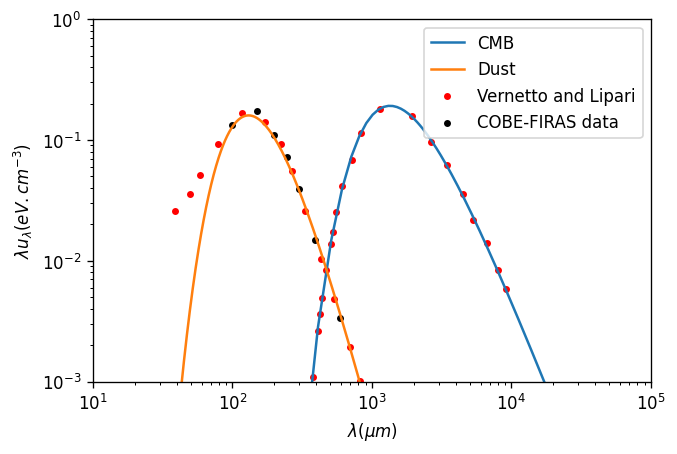

In [18]:
# Plotting energy density for CMB and dust
plt.figure (dpi=120)

# Our data
plt.plot (CMB_wvlg,CMB_Ed, label='CMB')
plt.plot(lambda_range, E_density_dust2, label='Dust')

# Scale
plt.xscale ('log')
plt.yscale ('log')

#Limits
plt.ylim ([1e-3,1])
plt.xlim([10,1e5])

#Labels
plt.xlabel ('$\lambda(\mu m)$')
plt.ylabel ('$\lambda u_{\lambda}(eV.cm^{-3})$')

#Extracted data
plt.scatter(x_en_density,y_en_density,color='red',label='Vernetto and Lipari',s=10)
plt.scatter(xLipari,yLipari, color='red', s=10)
plt.scatter(xFiras,yFiras, color='black',s=10, label='COBE-FIRAS data')

plt.legend()

In [19]:
 # CMB density using scipY.QUAD  #1

T= kelvin_to_cm(2.7255,1) # Change kelvin to cm^-1x
quad=integrate.quad (lambda x: 8*np.pi*T**3 *x**2/(np.exp(x)-1),0,10000)[0]

In [20]:
quad

410.6013167670191

In [21]:
# Number density using Numpy TRAPEZOID #2

energies=np.logspace (-9,-2,1000)
mnm=bb_energy(2.7255)
numpy_trapz= np.trapz(mnm,energies)

In [22]:
#  Cumulative Trapezoid #3

cumtrapz= integrate.cumtrapz(mnm,energies)[-1]

In [23]:
# CMB DENSITY USING ONLINE TRAPEZOID #4

T= kelvin_to_cm(2.7255,1)
def N(x):
    return (8*np.pi*T**3*x**2/(np.exp(x)-1))

online_trapz= trape(1e-11,1e2,10000)

In [24]:
online_trapz

410.5998935087756

In [25]:
# photon density using zeta function  #5

def density(T):
    zeta3=1.202056901178332
    d=2*zeta3*8*np.pi*(k*T/c/h)**3
    return (d/1e6)

zeta= density(2.7255)

In [26]:
zeta

410.7268472478743

In [20]:
# Before running change bb_energy
integration_points=np.arange (2,100000,1000)

trapz=[]
on_trapz=[]
cumtrap=[]
py_quads=[]
simps=[]

for i in integration_points:
    i=int (i)
    
    #Normal trapz
    energies=np.logspace (-11,2,i)
    mnm=bb_energy(2.7255)
    diff=abs(zeta-np.trapz(mnm,energies))/zeta
    trapz.append (diff)
    
    # Cumulative trapezoid 
    heh=integrate.cumtrapz(mnm,energies)
    cumtrap.append (abs(heh[-1]-zeta)/zeta)
    
    #Online trapz
    diff=abs(zeta-trape(1e-11,1e2,i))/zeta
    on_trapz.append (diff)
    
    #Quad
    py_quad=integrate.quad (lambda x: 8*np.pi*T**3 *x**2/(np.exp(x)-1),0,i)[0]
    diff=abs(zeta-py_quad)/zeta
    py_quads.append(diff)
    
    #Simpson
    simp=integrate.simpson(mnm,energies)
    diff=abs(simp-zeta)/zeta
    simps.append (diff)

KeyboardInterrupt: 

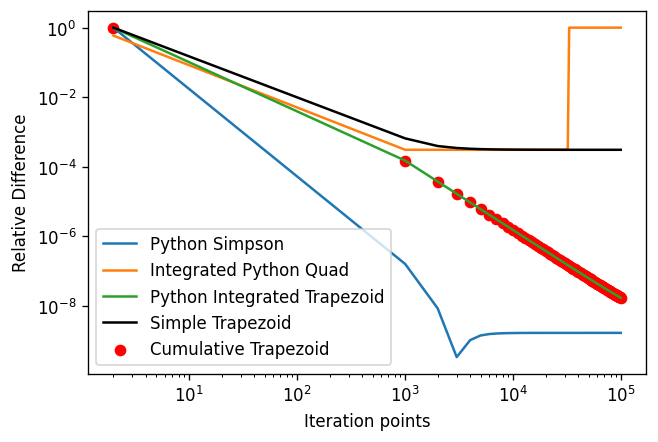

In [355]:
# 

plt.figure (dpi=120)

plt.plot (integration_points, simps, label= 'Python Simpson')
plt.plot (integration_points, py_quads, label='Integrated Python Quad')
plt.plot (integration_points,trapz, label='Python Integrated Trapezoid')
plt.plot (integration_points, on_trapz, label='Simple Trapezoid', color='black')
plt.scatter (integration_points, cumtrap, label ='Cumulative Trapezoid', color='red')

plt.xscale ('log')
plt.yscale ('log')

plt.xlabel ('Iteration points')
plt.ylabel ('Relative Difference')

plt.legend()


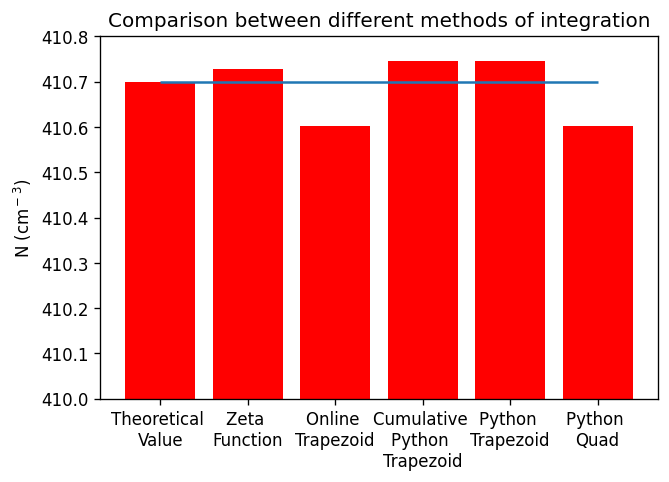

In [228]:
plt.figure (dpi=120)

values = [410.7,zeta, online_trapz, cumtrapz[-1], numpy_trapz,quad]
####
percentages=[]
for i in values:
    percentages.append (abs(i-410.7)/410.7)
######
labels = ['Theoretical \nValue','Zeta \nFunction', 'Online \nTrapezoid', 'Cumulative \nPython \nTrapezoid', 'Python \nTrapezoid','Python \nQuad']

plt.subplot()
plt.bar(labels, values, color='red')
plt.ylim([410,410.8])
plt.ylabel('N (cm$^-$$^3$)')
plt.title ('Comparison between different methods of integration')
plt.hlines(410.7,xmin='Theoretical \nValue', xmax='Python \nQuad')
plt.show()

In [27]:
# Extracting points from Lipari and Vernetto to compare 
# By using a function written above 'data_extractor'

cs_datapoints='/home/chris/Desktop/APC_internship/extractor/CS_datapoints_vernetto_lipari.csv'
x_cs=data_extractor(cs_datapoints)[0]
y_cs=data_extractor(cs_datapoints)[1]

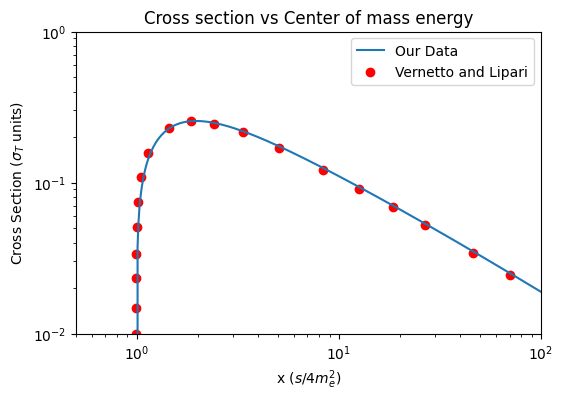

In [28]:
# x=s/4m^2   (s = center of mass energy squared)
# beta = sqrt (1-1/x)
# Cross section vs x

x=np.linspace (1,1e3,100000)
betas=[]
sigmas=[]
for i in (x):
    betas.append ((1-1/i)**0.5)
for i in (betas):
    sigma=3/16 * (1-i**2)*(2*i*(i**2-2)+(3-i**4)*np.log((1+i)/(1-i)))
    sigmas.append (sigma)

    
plt.figure (dpi=100)
plt.plot (x,sigmas,label='Our Data')
plt.xscale ('log')
plt.yscale ('log')
plt.xlim([0.5,1e2])
plt.ylim([1e-2,1])
plt.xlabel('x ($s/4m_e^2$)')
plt.ylabel ('Cross Section ($\sigma$$_T$ units)')
plt.title ('Cross section vs Center of mass energy')
plt.scatter(x_cs,y_cs,color='red',label='Vernetto and Lipari')
plt.legend()

In [29]:
# Function to calculate INTEGRATION OVER CROSS SECTION 
# In terms of x

avg_eps=ev_to_cm(6.34e-4,1)
T=kelvin_to_cm(2.7255,1)
m_electron=ev_to_cm(me,1)

# Define epsilon range in log space

eps=np.logspace(-11,2,1000)

# Defining it in cm
eps_cm=[]
for i in range (len(eps)):
    eps_cm.append(ev_to_cm(eps[i],1))

# Cross section amplitude found analytically

cross_section_amplitude= 3/8*thomson

# Integrate cross section

def int_cs(E):
    x0=[]
    cross_s=[] 
    eps_limit= me**2/E
    
    for i in (eps):
        x0.append (E*i/me**2)
        
    
    for j in range (len(x0)):
        # Condition on epsilon, aka x0
        if x0[j]<=1:
            cross_s.append(0)
            
        elif x0[j]>1:
            # Create a logspace space array to calculate the f(x)
            logx0=np.log10(x0[j])
            x=np.logspace (0,logx0,1000)
            f=[]
            for i in x:
                f.append (cross_section_amplitude*i/(x0[j])**2 *(2*np.sqrt(1-1/i)*(-1-1/i)+(3-(1-1/i)**2)*np.log((1+np.sqrt(1-1/i))/(1-np.sqrt(1-1/i)))))
            
            # Create a logspace array to integrate over
            y=[]
            for i in x:
                y.append (np.log(i))
                
            # Add the integration to an array
            cross_s.append (integrate.simpson(f,y))
    
    return (cross_s, x0, eps_limit)

In [30]:
### Before running change bb_energy ###

# CMB ABSORPTION

# Define Energy Range
Es=np.logspace (13,19,50)
#Es=[1e13]
CMB_E=np.logspace (-11,2,1000)
energies=CMB_E
CMB_N=bb_energy(2.7255)

K=[]
# Calculate Absorption for every energy
for i in (Es):
    integral= int_cs(i)
    cs=integral[0]
    limit=integral[2]
    
    # Introduce condition on epsilon (Integrate starting from epsilon>limit)
    reduced_CMB_N=[]
    reduced_CMB_E=[]
    
    for kk in range (len(CMB_E)):
        if CMB_E[kk]>limit:
            reduced_CMB_E.append (CMB_E[kk])
            reduced_CMB_N.append (CMB_N[kk])
    
    if len(reduced_CMB_E)==0:
        K.append (0)
        continue
    # Create interpolation function for the 1st integral
    g=interp1d(np.log(eps),cs, kind='quadratic')   
    
    absorption_CMB=[]
    for j in range (len(reduced_CMB_E)):
        en=np.log(reduced_CMB_E[j])
        absorption_CMB.append (cm_to_kpc(reduced_CMB_N[j]*float(g(en)),1))
    K.append (integrate.simpson(absorption_CMB,np.log(reduced_CMB_E)))

In [31]:
# Absorption comparison with Vernetto and Lipari
# Using function defined above (data_extractor)

abso='/home/chris/Desktop/APC_internship/extractor/K_datapoints_vernetLipar.csv'
x_K=data_extractor(abso)[0]
y_K=data_extractor(abso)[1]

abso2='/home/chris/Desktop/APC_internship/extractor/Lee_abso.csv'
x2_K=data_extractor(abso2)[0]
y2_K=data_extractor(abso2)[1]

# change Lee data from Mpc-1 to Kpc-1
for i in range (len(x2_K)):
    y2_K[i]=y2_K[i]*1e-3

In [32]:
# Extract number density with oscillations approximation into an interpolated model

# PL0
extended_Ndust='/home/chris/Desktop/APC_internship/extractor/Extended_N_density_Dust.csv'
x_Ndust_extended=data_extractor(extended_Ndust)[0]
y_Ndust_extended=data_extractor(extended_Ndust)[1]

# Model with oscillations to try to explain difference in amplitude

test_N0= nb_density_dust2[0:712]
test_eps0=list( epsilon_range_dust[0:712])
for i in range (10,len(x_Ndust_extended)):
    test_N0.append (y_Ndust_extended[i])
    test_eps0.append (x_Ndust_extended[i])

model0=interp1d(np.log(test_eps0),test_N0, kind='quadratic')

# extract 3 different power laws
powerlaw1='/home/chris/Desktop/APC_internship/extractor/PL1.csv'
powerlaw2='/home/chris/Desktop/APC_internship/extractor/PL2.csv'
powerlaw3='/home/chris/Desktop/APC_internship/extractor/PL3.csv'

# PL1
xPL1=data_extractor(powerlaw1)[0]
yPL1=data_extractor(powerlaw1)[1]

test_N1=nb_density_dust2[0:712]
test_eps1=list(epsilon_range_dust[0:712])
for i in range (20, len(xPL1)):
    test_N1.append (yPL1[i])
    test_eps1.append (xPL1[i])
    
model1=interp1d(np.log(test_eps1),test_N1)

# PL2
xPL2=data_extractor(powerlaw2)[0]
yPL2=data_extractor(powerlaw2)[1]

test_N2=nb_density_dust2[0:712]
test_eps2=list(epsilon_range_dust[0:712])
for i in range (20, len(xPL2)):
    test_N2.append (yPL2[i])
    test_eps2.append (xPL2[i])
    
model2=interp1d(np.log(test_eps2),test_N2)

# PL3
xPL3=data_extractor(powerlaw3)[0]
yPL3=data_extractor(powerlaw3)[1]

test_N3=nb_density_dust2[0:712]
test_eps3=list(epsilon_range_dust[0:712])
for i in range (20, len(xPL3)):
    test_N3.append (yPL3[i])
    test_eps3.append (xPL3[i])
    
model3=interp1d(np.log(test_eps3),test_N3)

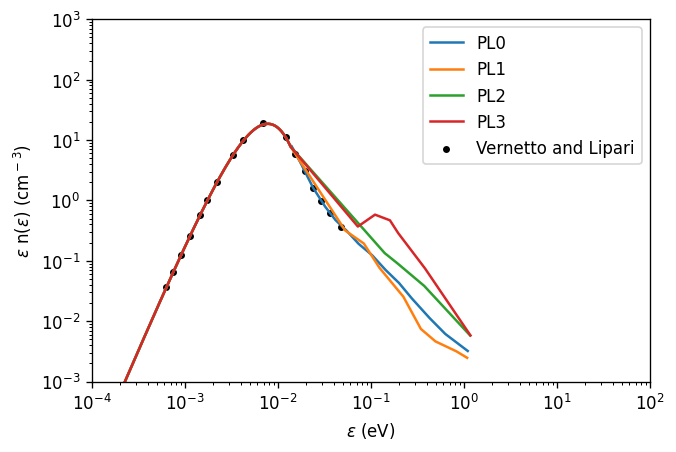

In [33]:
plt.figure (dpi=120)

plt.plot (test_eps0, test_N0, label='PL0')
plt.plot (test_eps1, test_N1, label ='PL1')
plt.plot (test_eps2, test_N2, label ='PL2')
plt.plot (test_eps3, test_N3, label ='PL3')

plt.scatter (x_Ndust,y_Ndust, label='Vernetto and Lipari', s=10, color='black')

plt.xscale ('log')
plt.yscale ('log')

plt.xlim([1e-4, 100])
plt.ylim([1e-3,1e3])

plt.xlabel ('$\epsilon$ (eV)')
plt.ylabel('$\epsilon$ n($\epsilon$) (cm$^-$$^3$)')

plt.legend()

In [34]:
## CALCULATE DUST ABSORPTION

Es_dust=np.logspace (13,17,50)

muss=[]
epsilon_range_dust=np.linspace (1e-4,0.025,1000)
for i in epsilon_range_dust:
    muss.append (i/h*e)
    
nb_density_dust=MBB(T=19.7,beta=1.62,ref_mu=353e9,mus=muss,I0=9.6e-7)[1]

K_dust=[]
K_PL0=[]
K_PL1=[]
K_PL2=[]
K_PL3=[]

# Calculate Absorption for every energy
for i in (Es_dust):
    integral= int_cs(i)
    cs=integral[0]
    limit=integral[2]
    
    # Introduce condition on epsilon (Integrate starting from epsilon>limit)
    reduced_dust_N=[]
    reduced_dust_E=[]
    
    for kk in range (len(epsilon_range_dust)):
        if epsilon_range_dust[kk]>limit:
            reduced_dust_E.append (epsilon_range_dust[kk])
            reduced_dust_N.append (nb_density_dust[kk])
    
    if len(reduced_dust_E)==0:
        K_dust.append (0)
        K_PL0.append (0)
        K_PL1.append(0)
        K_PL2.append(0)
        K_PL3.append (0)
        continue
    # Create interpolation function for the 1st integral
    g_dust=interp1d(np.log(eps),cs, kind='quadratic')   
    
    absorption_dust=[]
    absorption_PL0=[]
    absorption_PL1=[]
    absorption_PL2=[]
    absorption_PL3=[]
    
    for j in range (len(reduced_dust_E)):
        en=np.log(reduced_dust_E[j])
        
        absorption_dust.append (cm_to_kpc(reduced_dust_N[j]*(float(g_dust(en))),1))
        absorption_PL0.append (cm_to_kpc(model0(en)*(float(g_dust(en))),1)) 
        absorption_PL1.append (cm_to_kpc(model1(en)*(float(g_dust(en))),1))
        absorption_PL2.append (cm_to_kpc(model2(en)*(float(g_dust(en))),1)) 
        absorption_PL3.append (cm_to_kpc(model3(en)*(float(g_dust(en))),1)) 
        
    K_dust.append (integrate.simpson(absorption_dust,np.log(reduced_dust_E)))
    K_PL0.append (integrate.simpson(absorption_PL0,np.log(reduced_dust_E)))
    K_PL1.append (integrate.simpson(absorption_PL1,np.log(reduced_dust_E)))
    K_PL2.append (integrate.simpson(absorption_PL2,np.log(reduced_dust_E)))
    K_PL3.append (integrate.simpson(absorption_PL3,np.log(reduced_dust_E)))

In [35]:
# EXTRACT DUST ABSORPTION DATA POINTS

abs_dust='/home/chris/Desktop/APC_internship/extractor/dust_K.csv'
x_Kdust=data_extractor(abs_dust)[0]
y_Kdust=data_extractor(abs_dust)[1]

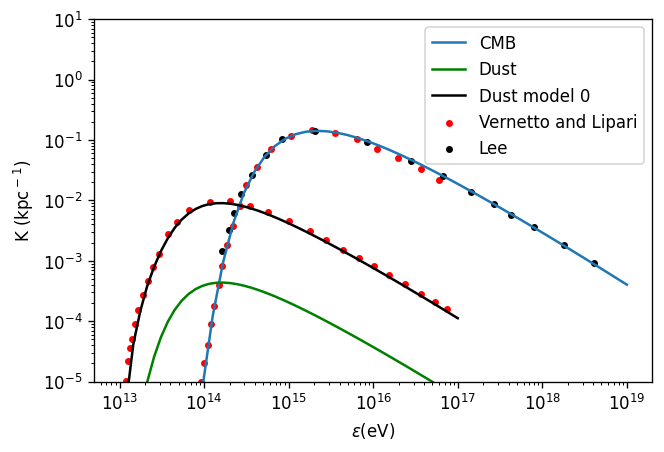

In [52]:
plt.figure (dpi=120)
dust20=[]
for i in(K_dust):
    dust20.append (i)
    
plt.plot (Es,K,label='CMB')
plt.plot (Es_dust,K_dust, label='Dust', color='green')
#plt.plot (Es_dust, modifiedK, label='Dust amplified', color='orange')
plt.plot (Es_dust, K_PL0, label ='Dust model 0', color='black')
#plt.plot (Es_dust, K_PL1, label='Dust model 1',color='red')
#plt.plot (Es_dust, K_PL2, label='Dust model 2',color='orange')
#plt.plot (Es_dust, K_PL3, label='Dust model 3',color='magenta')

plt.xscale ('log')
plt.yscale ('log')

plt.xlabel ('$\epsilon$(eV)')
plt.ylabel ('K (kpc$^-$$^1$)')

plt.ylim([1e-5,10])

plt.scatter (x_K,y_K, color='red',label='Vernetto and Lipari',s=10)
plt.scatter (x2_K,y2_K, color='black', label='Lee', s=10)
plt.scatter (x_Kdust,y_Kdust, s=10, color='red')

plt.legend()

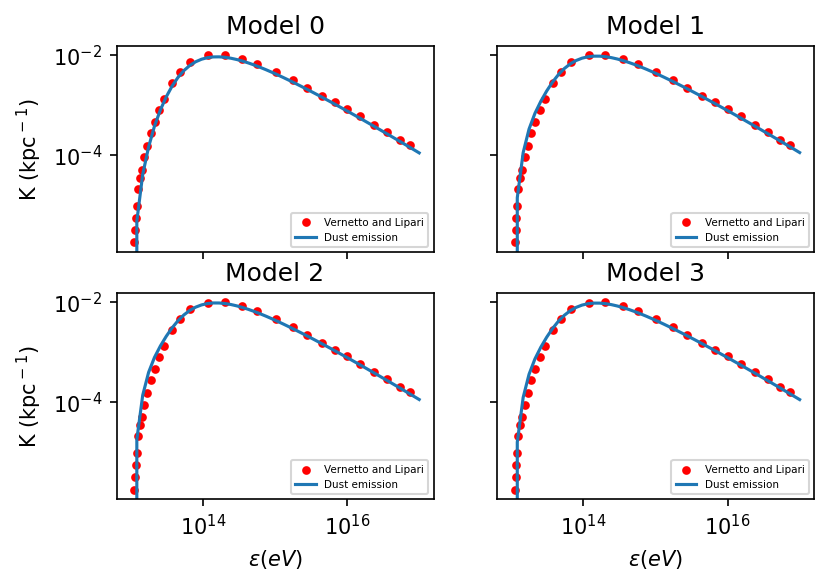

In [37]:
# Create 2x2 figure
fig,axs=plt.subplots(2,2)
fig.set_dpi(150)

# Subplot 1 manip
axs[0,0].scatter (x_Kdust,y_Kdust, s=10, color='red',label='Vernetto and Lipari')
axs[0,0].loglog (Es_dust, K_PL0, label='Dust emission')
axs[0,0].set_title('Model 0')
axs[0,0].legend(loc='lower right', fontsize=5)

# Subplot 2 manip
axs[0,1].scatter (x_Kdust,y_Kdust, s=10, color='red',label='Vernetto and Lipari')
axs[0,1].loglog (Es_dust,K_PL1, label='Dust emission')
axs[0,1].set_title ('Model 1')
axs[0,1].legend(loc='lower right', fontsize=5)

# Subplot 3 manip
axs[1,0].scatter (x_Kdust,y_Kdust, s=10, color='red',label='Vernetto and Lipari')
axs[1,0].loglog (Es_dust,K_PL2, label='Dust emission')
axs[1,0].set_title ('Model 2')
axs[1,0].legend(loc='lower right',fontsize=5)

# Subplot 4 manip
axs[1,1].scatter (x_Kdust,y_Kdust, s=10, color='red',label='Vernetto and Lipari')
axs[1,1].loglog (Es_dust,K_PL3, label='Dust emission')
axs[1,1].set_title ('Model 3')
axs[1,1].legend(loc='lower right', fontsize=5)

# Define axis labels
for ax in axs.flat:
    ax.set(xlabel='$\epsilon(eV)$', ylabel='K (kpc$^-$$^1$)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

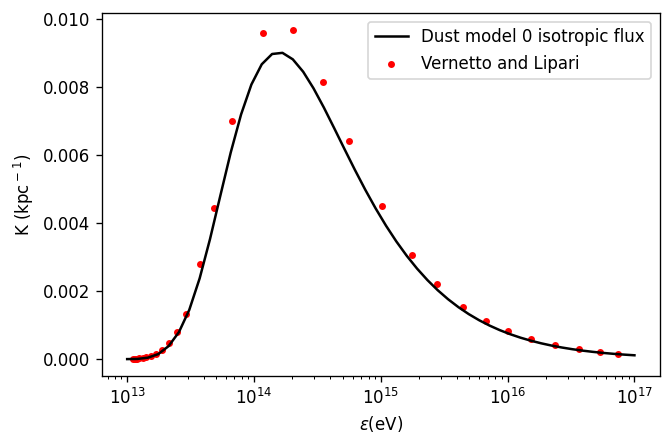

In [56]:
toGC=[]
awayGC=[]
for i in (K_PL0):
    toGC.append (i*38)
    
plt.figure (dpi=120)

plt.plot (Es_dust, K_PL0, label ='Dust model 0 isotropic flux', color='black')
#plt.plot (Es_dust, toGC)

plt.xlabel ('$\epsilon$(eV)')
plt.ylabel ('K (kpc$^-$$^1$)')

#plt.ylim([1e-5,10])
plt.scatter (x_Kdust,y_Kdust, s=10, color='red', label ='Vernetto and Lipari')
plt.xscale ('log')
plt.legend()

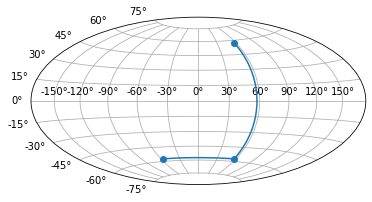

In [205]:
import matplotlib
from matplotlib.axes import Axes
from matplotlib.patches import Circle
from matplotlib.path import Path
from matplotlib.ticker import NullLocator, Formatter, FixedLocator
from matplotlib.transforms import Affine2D, BboxTransformTo, Transform
from matplotlib.projections import register_projection
import matplotlib.spines as mspines
import matplotlib.axis as maxis
import numpy as np

rcParams = matplotlib.rcParams

# This example projection class is rather long, but it is designed to
# illustrate many features, not all of which will be used every time.
# It is also common to factor out a lot of these methods into common
# code used by a number of projections with similar characteristics
# (see geo.py).


class GeoAxes(Axes):
    """
    An abstract base class for geographic projections
    """
    class ThetaFormatter(Formatter):
        """
        Used to format the theta tick labels.  Converts the native
        unit of radians into degrees and adds a degree symbol.
        """
        def __init__(self, round_to=1.0):
            self._round_to = round_to

        def __call__(self, x, pos=None):
            degrees = round(np.rad2deg(x) / self._round_to) * self._round_to
            return f"{degrees:0.0f}\N{DEGREE SIGN}"

    RESOLUTION = 75

    def _init_axis(self):
        self.xaxis = maxis.XAxis(self)
        self.yaxis = maxis.YAxis(self)
        # Do not register xaxis or yaxis with spines -- as done in
        # Axes._init_axis() -- until GeoAxes.xaxis.clear() works.
        # self.spines['geo'].register_axis(self.yaxis)

    def clear(self):
        # docstring inherited
        super().clear()

        self.set_longitude_grid(30)
        self.set_latitude_grid(15)
        self.set_longitude_grid_ends(75)
        self.xaxis.set_minor_locator(NullLocator())
        self.yaxis.set_minor_locator(NullLocator())
        self.xaxis.set_ticks_position('none')
        self.yaxis.set_ticks_position('none')
        self.yaxis.set_tick_params(label1On=True)
        # Why do we need to turn on yaxis tick labels, but
        # xaxis tick labels are already on?

        self.grid(rcParams['axes.grid'])

        Axes.set_xlim(self, -np.pi, np.pi)
        Axes.set_ylim(self, -np.pi / 2.0, np.pi / 2.0)

    def _set_lim_and_transforms(self):
        # A (possibly non-linear) projection on the (already scaled) data

        # There are three important coordinate spaces going on here:
        #
        # 1. Data space: The space of the data itself
        #
        # 2. Axes space: The unit rectangle (0, 0) to (1, 1)
        #    covering the entire plot area.
        #
        # 3. Display space: The coordinates of the resulting image,
        #    often in pixels or dpi/inch.

        # This function makes heavy use of the Transform classes in
        # ``lib/matplotlib/transforms.py.`` For more information, see
        # the inline documentation there.

        # The goal of the first two transformations is to get from the
        # data space (in this case longitude and latitude) to axes
        # space.  It is separated into a non-affine and affine part so
        # that the non-affine part does not have to be recomputed when
        # a simple affine change to the figure has been made (such as
        # resizing the window or changing the dpi).

        # 1) The core transformation from data space into
        # rectilinear space defined in the HammerTransform class.
        self.transProjection = self._get_core_transform(self.RESOLUTION)

        # 2) The above has an output range that is not in the unit
        # rectangle, so scale and translate it so it fits correctly
        # within the axes.  The peculiar calculations of xscale and
        # yscale are specific to an Aitoff-Hammer projection, so don't
        # worry about them too much.
        self.transAffine = self._get_affine_transform()

        # 3) This is the transformation from axes space to display
        # space.
        self.transAxes = BboxTransformTo(self.bbox)

        # Now put these 3 transforms together -- from data all the way
        # to display coordinates.  Using the '+' operator, these
        # transforms will be applied "in order".  The transforms are
        # automatically simplified, if possible, by the underlying
        # transformation framework.
        self.transData = \
            self.transProjection + \
            self.transAffine + \
            self.transAxes

        # The main data transformation is set up.  Now deal with
        # gridlines and tick labels.

        # Longitude gridlines and ticklabels.  The input to these
        # transforms are in display space in x and axes space in y.
        # Therefore, the input values will be in range (-xmin, 0),
        # (xmax, 1).  The goal of these transforms is to go from that
        # space to display space.  The tick labels will be offset 4
        # pixels from the equator.
        self._xaxis_pretransform = \
            Affine2D() \
            .scale(1.0, self._longitude_cap * 2.0) \
            .translate(0.0, -self._longitude_cap)
        self._xaxis_transform = \
            self._xaxis_pretransform + \
            self.transData
        self._xaxis_text1_transform = \
            Affine2D().scale(1.0, 0.0) + \
            self.transData + \
            Affine2D().translate(0.0, 4.0)
        self._xaxis_text2_transform = \
            Affine2D().scale(1.0, 0.0) + \
            self.transData + \
            Affine2D().translate(0.0, -4.0)

        # Now set up the transforms for the latitude ticks.  The input to
        # these transforms are in axes space in x and display space in
        # y.  Therefore, the input values will be in range (0, -ymin),
        # (1, ymax).  The goal of these transforms is to go from that
        # space to display space.  The tick labels will be offset 4
        # pixels from the edge of the axes ellipse.
        yaxis_stretch = Affine2D().scale(np.pi*2, 1).translate(-np.pi, 0)
        yaxis_space = Affine2D().scale(1.0, 1.1)
        self._yaxis_transform = \
            yaxis_stretch + \
            self.transData
        yaxis_text_base = \
            yaxis_stretch + \
            self.transProjection + \
            (yaxis_space +
             self.transAffine +
             self.transAxes)
        self._yaxis_text1_transform = \
            yaxis_text_base + \
            Affine2D().translate(-8.0, 0.0)
        self._yaxis_text2_transform = \
            yaxis_text_base + \
            Affine2D().translate(8.0, 0.0)

    def _get_affine_transform(self):
        transform = self._get_core_transform(1)
        xscale, _ = transform.transform((np.pi, 0))
        _, yscale = transform.transform((0, np.pi/2))
        return Affine2D() \
            .scale(0.5 / xscale, 0.5 / yscale) \
            .translate(0.5, 0.5)

    def get_xaxis_transform(self, which='grid'):
        """
        Override this method to provide a transformation for the
        x-axis tick labels.

        Returns a tuple of the form (transform, valign, halign)
        """
        if which not in ['tick1', 'tick2', 'grid']:
            raise ValueError(
                "'which' must be one of 'tick1', 'tick2', or 'grid'")
        return self._xaxis_transform

    def get_xaxis_text1_transform(self, pad):
        return self._xaxis_text1_transform, 'bottom', 'center'

    def get_xaxis_text2_transform(self, pad):
        """
        Override this method to provide a transformation for the
        secondary x-axis tick labels.

        Returns a tuple of the form (transform, valign, halign)
        """
        return self._xaxis_text2_transform, 'top', 'center'

    def get_yaxis_transform(self, which='grid'):
        """
        Override this method to provide a transformation for the
        y-axis grid and ticks.
        """
        if which not in ['tick1', 'tick2', 'grid']:
            raise ValueError(
                "'which' must be one of 'tick1', 'tick2', or 'grid'")
        return self._yaxis_transform

    def get_yaxis_text1_transform(self, pad):
        """
        Override this method to provide a transformation for the
        y-axis tick labels.

        Returns a tuple of the form (transform, valign, halign)
        """
        return self._yaxis_text1_transform, 'center', 'right'

    def get_yaxis_text2_transform(self, pad):
        """
        Override this method to provide a transformation for the
        secondary y-axis tick labels.

        Returns a tuple of the form (transform, valign, halign)
        """
        return self._yaxis_text2_transform, 'center', 'left'

    def _gen_axes_patch(self):
        """
        Override this method to define the shape that is used for the
        background of the plot.  It should be a subclass of Patch.

        In this case, it is a Circle (that may be warped by the axes
        transform into an ellipse).  Any data and gridlines will be
        clipped to this shape.
        """
        return Circle((0.5, 0.5), 0.5)

    def _gen_axes_spines(self):
        return {'geo': mspines.Spine.circular_spine(self, (0.5, 0.5), 0.5)}

    def set_yscale(self, *args, **kwargs):
        if args[0] != 'linear':
            raise NotImplementedError

    # Prevent the user from applying scales to one or both of the
    # axes.  In this particular case, scaling the axes wouldn't make
    # sense, so we don't allow it.
    set_xscale = set_yscale

    # Prevent the user from changing the axes limits.  In our case, we
    # want to display the whole sphere all the time, so we override
    # set_xlim and set_ylim to ignore any input.  This also applies to
    # interactive panning and zooming in the GUI interfaces.
    def set_xlim(self, *args, **kwargs):
        raise TypeError("Changing axes limits of a geographic projection is "
                        "not supported.  Please consider using Cartopy.")

    set_ylim = set_xlim

    def format_coord(self, lon, lat):
        """
        Override this method to change how the values are displayed in
        the status bar.

        In this case, we want them to be displayed in degrees N/S/E/W.
        """
        lon, lat = np.rad2deg([lon, lat])
        ns = 'N' if lat >= 0.0 else 'S'
        ew = 'E' if lon >= 0.0 else 'W'
        return ('%f\N{DEGREE SIGN}%s, %f\N{DEGREE SIGN}%s'
                % (abs(lat), ns, abs(lon), ew))

    def set_longitude_grid(self, degrees):
        """
        Set the number of degrees between each longitude grid.

        This is an example method that is specific to this projection
        class -- it provides a more convenient interface to set the
        ticking than set_xticks would.
        """
        # Skip -180 and 180, which are the fixed limits.
        grid = np.arange(-180 + degrees, 180, degrees)
        self.xaxis.set_major_locator(FixedLocator(np.deg2rad(grid)))
        self.xaxis.set_major_formatter(self.ThetaFormatter(degrees))

    def set_latitude_grid(self, degrees):
        """
        Set the number of degrees between each longitude grid.

        This is an example method that is specific to this projection
        class -- it provides a more convenient interface than
        set_yticks would.
        """
        # Skip -90 and 90, which are the fixed limits.
        grid = np.arange(-90 + degrees, 90, degrees)
        self.yaxis.set_major_locator(FixedLocator(np.deg2rad(grid)))
        self.yaxis.set_major_formatter(self.ThetaFormatter(degrees))

    def set_longitude_grid_ends(self, degrees):
        """
        Set the latitude(s) at which to stop drawing the longitude grids.

        Often, in geographic projections, you wouldn't want to draw
        longitude gridlines near the poles.  This allows the user to
        specify the degree at which to stop drawing longitude grids.

        This is an example method that is specific to this projection
        class -- it provides an interface to something that has no
        analogy in the base Axes class.
        """
        self._longitude_cap = np.deg2rad(degrees)
        self._xaxis_pretransform \
            .clear() \
            .scale(1.0, self._longitude_cap * 2.0) \
            .translate(0.0, -self._longitude_cap)

    def get_data_ratio(self):
        """
        Return the aspect ratio of the data itself.

        This method should be overridden by any Axes that have a
        fixed data ratio.
        """
        return 1.0

    # Interactive panning and zooming is not supported with this projection,
    # so we override all of the following methods to disable it.
    def can_zoom(self):
        """
        Return whether this Axes supports the zoom box button functionality.

        This Axes object does not support interactive zoom box.
        """
        return False

    def can_pan(self):
        """
        Return whether this Axes supports the pan/zoom button functionality.

        This Axes object does not support interactive pan/zoom.
        """
        return False

    def start_pan(self, x, y, button):
        pass

    def end_pan(self):
        pass

    def drag_pan(self, button, key, x, y):
        pass


class HammerAxes(GeoAxes):
    """
    A custom class for the Aitoff-Hammer projection, an equal-area map
    projection.

    https://en.wikipedia.org/wiki/Hammer_projection
    """

    # The projection must specify a name. This will be used by the
    # user to select the projection,
    # i.e. ``subplot(projection='custom_hammer')``.
    name = 'custom_hammer'

    class HammerTransform(Transform):
        """The base Hammer transform."""
        input_dims = output_dims = 2

        def __init__(self, resolution):
            """
            Create a new Hammer transform.  Resolution is the number of steps
            to interpolate between each input line segment to approximate its
            path in curved Hammer space.
            """
            Transform.__init__(self)
            self._resolution = resolution

        def transform_non_affine(self, ll):
            longitude, latitude = ll.T

            # Pre-compute some values
            half_long = longitude / 2
            cos_latitude = np.cos(latitude)
            sqrt2 = np.sqrt(2)

            alpha = np.sqrt(1 + cos_latitude * np.cos(half_long))
            x = (2 * sqrt2) * (cos_latitude * np.sin(half_long)) / alpha
            y = (sqrt2 * np.sin(latitude)) / alpha
            return np.column_stack([x, y])

        def transform_path_non_affine(self, path):
            # vertices = path.vertices
            ipath = path.interpolated(self._resolution)
            return Path(self.transform(ipath.vertices), ipath.codes)

        def inverted(self):
            return HammerAxes.InvertedHammerTransform(self._resolution)

    class InvertedHammerTransform(Transform):
        input_dims = output_dims = 2

        def __init__(self, resolution):
            Transform.__init__(self)
            self._resolution = resolution

        def transform_non_affine(self, xy):
            x, y = xy.T
            z = np.sqrt(1 - (x / 4) ** 2 - (y / 2) ** 2)
            longitude = 2 * np.arctan((z * x) / (2 * (2 * z ** 2 - 1)))
            latitude = np.arcsin(y*z)
            return np.column_stack([longitude, latitude])

        def inverted(self):
            return HammerAxes.HammerTransform(self._resolution)

    def __init__(self, *args, **kwargs):
        self._longitude_cap = np.pi / 2.0
        super().__init__(*args, **kwargs)
        self.set_aspect(0.5, adjustable='box', anchor='C')
        self.clear()

    def _get_core_transform(self, resolution):
        return self.HammerTransform(resolution)


# Now register the projection with Matplotlib so the user can select it.
register_projection(HammerAxes)


if __name__ == '__main__':
    import matplotlib.pyplot as plt
    # Now make a simple example using the custom projection.
    fig, ax = plt.subplots(subplot_kw={'projection': 'custom_hammer'})
    ax.plot([-1, 1, 1], [-1, -1, 1], "o-")
    ax.grid()

    plt.show()

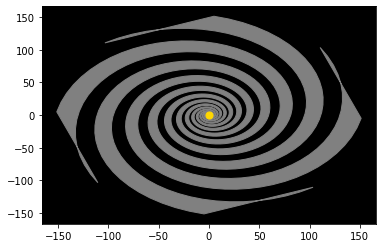

In [224]:
theta = np.arange(0, 8*np.pi, 0.1)
a = 1
b = .2

for dt in np.arange(0, 2*np.pi, np.pi/2.0):

    x = a*np.cos(theta + dt)*np.exp(b*theta)
    y = a*np.sin(theta + dt)*np.exp(b*theta)

    dt = dt + np.pi/4.0

    x2 = a*np.cos(theta + dt)*np.exp(b*theta)
    y2 = a*np.sin(theta + dt)*np.exp(b*theta)

    xf = np.concatenate((x, x2[::-1]))
    yf = np.concatenate((y, y2[::-1]))

    p1 = plt.fill(xf, yf, color='grey')
xc=0
yc=0
plt.scatter (xc,yc,color='gold', s=50)
ax=plt.gca()
ax.set_facecolor('black')
plt.show()

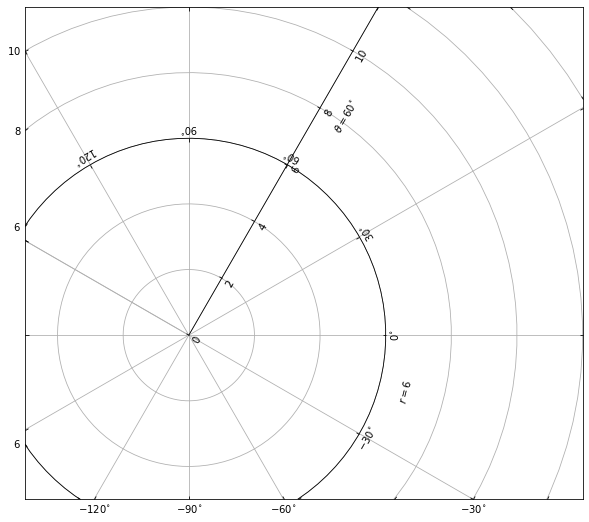

In [226]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist.angle_helper as angle_helper
from matplotlib.projections import PolarAxes
from matplotlib.transforms import Affine2D
from mpl_toolkits.axisartist import HostAxes
from mpl_toolkits.axisartist import GridHelperCurveLinear


def curvelinear_test2(fig):
    """Polar projection, but in a rectangular box."""
    # see demo_curvelinear_grid.py for details
    tr = Affine2D().scale(np.pi / 180., 1.) + PolarAxes.PolarTransform()

    extreme_finder = angle_helper.ExtremeFinderCycle(20,
                                                     20,
                                                     lon_cycle=360,
                                                     lat_cycle=None,
                                                     lon_minmax=None,
                                                     lat_minmax=(0, np.inf),
                                                     )

    grid_locator1 = angle_helper.LocatorDMS(12)

    tick_formatter1 = angle_helper.FormatterDMS()

    grid_helper = GridHelperCurveLinear(tr,
                                        extreme_finder=extreme_finder,
                                        grid_locator1=grid_locator1,
                                        tick_formatter1=tick_formatter1
                                        )

    ax1 = fig.add_subplot(axes_class=HostAxes, grid_helper=grid_helper)

    # Now creates floating axis

    # floating axis whose first coordinate (theta) is fixed at 60
    ax1.axis["lat"] = axis = ax1.new_floating_axis(0, 60)
    axis.label.set_text(r"$\theta = 60^{\circ}$")
    axis.label.set_visible(True)

    # floating axis whose second coordinate (r) is fixed at 6
    ax1.axis["lon"] = axis = ax1.new_floating_axis(1, 6)
    axis.label.set_text(r"$r = 6$")

    ax1.set_aspect(1.)
    ax1.set_xlim(-5, 12)
    ax1.set_ylim(-5, 10)

    ax1.grid(True)


fig = plt.figure(figsize=(7,7))
curvelinear_test2(fig)
plt.show()

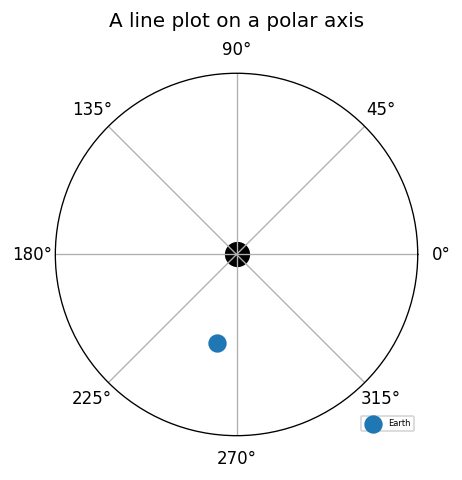

In [273]:
import numpy as np
import matplotlib.pyplot as plt

r = np.arange(0, 10, 0.01)
theta = 2 * np.pi * r
xc=0
yc=0

xEarth=4.5
yEarth=5

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

#ax.plot(theta, r)
ax.scatter (xc,yc, color='black', s=200)
ax.scatter (xEarth, yEarth, s=100, label ='Earth')
ax.legend(loc='lower right', fontsize=5)

ax.set_rmax(10)
ax.set_rticks([])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

fig.set_dpi(120)

ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()

Text(0.5, 1.0, 'Sky Map')

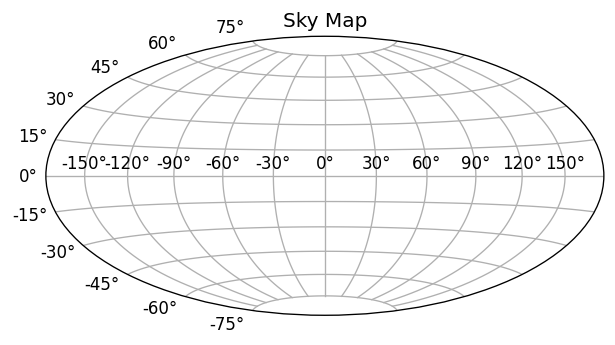

In [44]:
plt.figure(dpi=120)
plt.subplot (projection='hammer')
plt.grid()
plt.title ('Sky Map')